### Add the packages and add python to path

In [1]:
# packages and plot parameters
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import numpy.ma as ma
import glob
import os
import re
from operator import mul
import sys

plt.rcParams['figure.figsize'] = (10,4)

In [2]:
# add mds functions to path
# instead of this command:
# %load "/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/mds.py"
# we can do this one:
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

In [3]:
# add reading functions to path
def read_float32(fileIn):
    with open(fileIn, 'rb') as f:
        data = np.fromfile(f, dtype=np.dtype('>f'))
        print(np.shape(data))
    return data

def read_float64(fileIn):
    with open(fileIn, 'rb') as f:
        data = np.fromfile(f, dtype=np.dtype('>f8'))
        print(np.shape(data))
    return data

In [4]:
#Now try to create a read function that allows skip:
def read_float32_skip(fileIn,recordLen,recordNo):
    memArray = np.zeros(recordLen, dtype=np.dtype('>f')) # a buffer for 1 record
    with open(fileIn, 'rb') as file:
        # Reading a record recordNo from file into the fldout
        file.seek(recordLen * 4 * recordNo)
        bytes = file.read(recordLen*4)
        fldout = np.frombuffer(bytes, dtype=np.dtype('>f')).copy()
    return fldout

#Now try to create a read function that allows skip:
def read_float64_skip(fileIn,recordLen,recordNo):
    memArray = np.zeros(recordLen, dtype=np.dtype('>f')) # a buffer for 1 record
    with open(fileIn, 'rb') as file:
        # Reading a record recordNo from file into the fldout
        file.seek(recordLen * 8 * recordNo)
        bytes = file.read(recordLen*8)
        fldout = np.frombuffer(bytes, dtype=np.dtype('>f8')).copy()
    return fldout

### Load in the files from the run

In [17]:
# our directories
#dirrun = "/home/shoshi/MITgcm_c68r/mysetups/lab_sea_sshv4"
#dir_diags = dirrun + "diags/"
dirrun = '/home/shoshi/MITgcm_c68r/mysetups/lab_sea_sshv4/run_success/'

In [8]:
nx=20
ny=16
nz=23

(1600,)
(1600,)


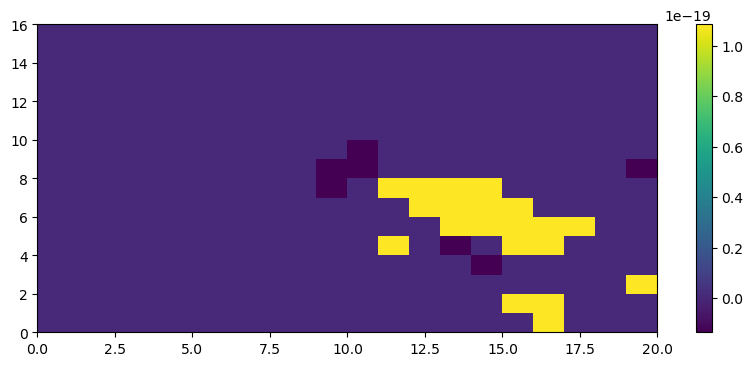

In [32]:
### TESTING 1/10/24
sladiff_tp = read_float32(dirrun + "sladiff_tp_raw.data")
sladiff_tp = sladiff_tp.reshape(5, 16,20)


slaobs_tp = read_float32(dirrun + "slaobs_tp_raw.data")
slaobs_tp = slaobs_tp.reshape(5, 16,20)

plt.pcolormesh(slaobs_tp[0,:,:])
plt.colorbar()

### Plot surface SST

In [12]:
# how did I know to run float64 here rather than float32?
# ls -l ../input_ad/labsea_SST_fields
# this shows 35840 --> 35/16/20/14 = 8

#d_sst = read_float64(dirrun + "labsea_SST_fields")
#d_sst = d_sst.reshape(14,16,20)
d_ssh = read_float64(dirrun + "ssh_data_8760rec_r8_1979")
d_ssh = d_ssh.reshape(24*365,16,20)

(2803200,)


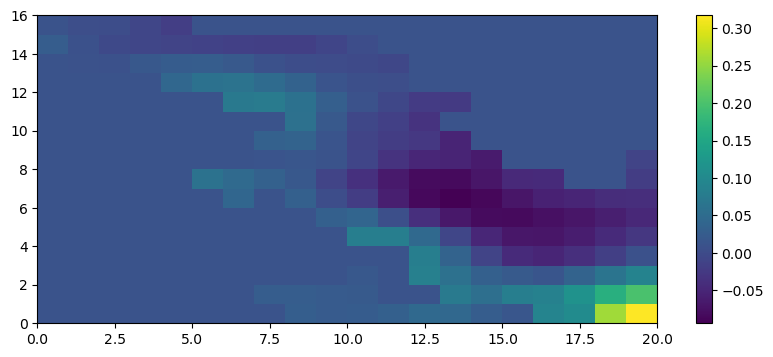

In [13]:
plt.pcolormesh(d_ssh[0,:,:])
plt.colorbar()

### Calculate the misfit for sst  --- DID THIS WITH AN, THIS IS TO PLOT MISFIT


In [23]:
# sigma standard deviation
#d_sigma = read_float64(dirrun + "sigma_sst.bin")
#d_sigma = d_sigma.reshape(1,16,20)

# model data
# gdims,i0s,ies,timeStepNumber,timeInterval,map2gl,meta = readmeta(dirrun + "m_sst_step.0000000000.meta")
#m_sst = rdmds(dirrun + "m_sst_step",0)
m_ssh = rdmds(dirrun + "m_eta_step",0)

# # misfit from data, this shows the degree of uncertainty of the model
# misfit = rdmds(dirrun + "misfit_sst", -1)

# calculate the misfit, d_sst is all 14 steps not just the 11 we asked for in the model
print(m_ssh.shape,d_ssh.shape)
misfit_calc = (m_ssh - d_ssh[:102])

(102, 16, 20) (8760, 16, 20)


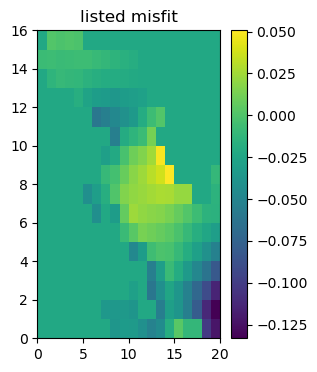

In [24]:
fig = plt.figure()
plt.subplot(1,3,1)
plt.title("listed misfit")
plt.pcolormesh(misfit_calc[1])
plt.colorbar()

# # do the subtraction, this should be 0 or close to 0
# plt.subplot(1,3,2)
# plt.title("calc - listed misfit")
# plt.pcolormesh(misfit_calc[1]-misfit[1])
# plt.colorbar()

# plt.subplot(1,3,3)
# plt.title("$\\sigma$")
# plt.pcolormesh(d_sigma[0],vmin=0.95)
# plt.colorbar()

### THIS IS TO CALCULATE THE MISFIT FOR THE DATA
### When you print out the nansum of the costfunction, it should be the same as is listed in your costfunction file

In [12]:
# calculate the residual
resid = misfit_calc[0]-misfit[0]
print(np.nansum(resid))

# tile sigma
tile_sigma = np.tile(d_sigma[0],(11,1,1))
# remove the land
tile_sigma[tile_sigma == 0] = np.nan

print(misfit_calc.shape,tile_sigma.shape)

# calculate the cost function, check that this is the same as in the file outputted "costfunction00000"
costfunction = (misfit_calc/tile_sigma)**2

print("check that this is the same as in the file? yes")
np.nansum(costfunction)

-0.0016999999570543878
(11, 16, 20) (11, 16, 20)
check that this is the same as in the file? yes


51045.58881931096

In [13]:
# not sure what these are for; did this with An to check
print(costfunction[~np.isnan(costfunction)].shape)
print(tile_sigma[tile_sigma != np.nan].flatten().shape)

(1650,)
(3520,)


### Calculate the misfit for theta  --- THIS IS WRONG

In [13]:
# real measured data
d_theta = read_float64(dirrun + "labsea_Lev.ptmp")
d_theta = d_theta.reshape(23,14,16,20)
# select only the first time step of this to test
d_theta_0 = d_theta[:,0,:,:] #][:][:][:]
print(d_theta_0.shape)

# sigma standard deviation
d_sigma = read_float64(dirrun + "sigma_theta.bin")
d_sigma = d_sigma.reshape(23,16,20)
print(d_sigma.shape)

# model data
# index 0 is at the sea surface
m_theta = rdmds(dirrun + "m_theta_month",0)
print(m_theta.shape)

# misfit from data, this shows the degree of uncertainty of the model
misfit = rdmds(dirrun + "misfit_theta", -1)
print(misfit.shape)

(103040,)
(23, 16, 20)
(7360,)
(23, 16, 20)
(23, 16, 20)
(23, 16, 20)


In [14]:
# calculate the misfit, d_sst is all 14 steps not just the 11 we asked for in the model
misfit_calc = (m_theta - d_theta_0)
print(m_theta.shape,d_theta.shape)

(23, 16, 20) (23, 14, 16, 20)


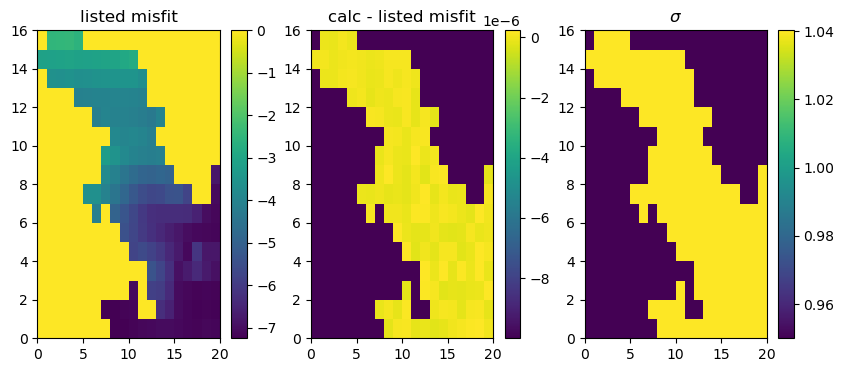

In [15]:
# try to plot this as in the previous exercise
fig = plt.figure()
plt.subplot(1,3,1)
plt.title("listed misfit")
plt.pcolormesh(misfit[0])
plt.colorbar()

# do the subtraction, this should be 0 or close to 0
plt.subplot(1,3,2)
plt.title("calc - listed misfit")
plt.pcolormesh(misfit_calc[0]-misfit[0])
plt.colorbar()

plt.subplot(1,3,3)
plt.title("$\\sigma$")
plt.pcolormesh(d_sigma[0],vmin=0.95)
plt.colorbar()

In [16]:
# calculate the residual
resid = misfit_calc[0]-misfit[0]
print(np.nansum(resid))

# tile sigma
# print(d_theta.shape)
tile_sigma = d_theta[:,0,:,:] #][:11][:][:]
tile_sigma[tile_sigma == 0] = np.nan
print(tile_sigma.shape)

# tile sigma
print(misfit_calc.shape)

# calculate the cost function, check that this is the same as in the file outputted "costfunction00000"
costfunction = (misfit_calc/tile_sigma)**2
np.nansum(costfunction)

-0.001700649680200339
(23, 16, 20)
(23, 16, 20)


60726039548398.484

### Reading in a simple file from layers

In [17]:
# this is the binned TH values
# 4 refers to 'LaUH1TH ' 'LaVH1TH ' 'LaUH2RHO' 'LaVH2RHO'
dir_diags = dirrun + "diags/"
diags_layers = rdmds(dir_diags + "DiagOcnLAYERS", 10)
print(diags_layers.shape)

(4, 40, 16, 20)


In [18]:
# read in the original array we fed
binsTH = rdmds(dirrun + "layers1TH", -1)
binflat = binsTH[:,:,0].flatten()
binavg = (binflat[:-1] + binflat[1:])/2
print(binflat)
print(binavg.shape)
print(binavg)

# read in the original array we fed
binsRHO = rdmds(dirrun + "layers2RHO", -1)
binflatrho = binsRHO[:,:,0].flatten()
print()
print(binflatrho)
binavgrho = (binflatrho[:-1] + binflatrho[1:])/2
print(binavgrho)

[-5. -4. -3. -2. -1.  0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12.
 13. 14. 15. 16. 17. 18. 19. 20. 21. 22. 23. 24. 25. 26. 27. 28. 29. 30.
 31. 32. 33. 34. 35.]
(40,)
[-4.5 -3.5 -2.5 -1.5 -0.5  0.5  1.5  2.5  3.5  4.5  5.5  6.5  7.5  8.5
  9.5 10.5 11.5 12.5 13.5 14.5 15.5 16.5 17.5 18.5 19.5 20.5 21.5 22.5
 23.5 24.5 25.5 26.5 27.5 28.5 29.5 30.5 31.5 32.5 33.5 34.5]

[17.         17.20000076 17.5        17.79999924 18.         18.20000076
 18.5        18.79999924 19.         19.20000076 19.5        19.79999924
 20.         20.20000076 20.5        20.79999924 21.         21.20000076
 21.5        21.79999924 22.         22.20000076 22.5        22.79999924
 23.         23.20000076 23.5        23.79999924 24.         24.20000076
 24.5        24.79999924 25.         25.20000076 25.5        25.79999924
 26.         26.20000076 26.5        26.79999924 27.        ]
[17.10000038 17.35000038 17.64999962 17.89999962 18.10000038 18.35000038
 18.64999962 18.89999962 19.10000038 19.35000038

### Try to calculate volume from the temperature and average depth

In [140]:
# get the first value (LaUH1TH) of the layers in T
diags_layers0 = diags_layers[0]
print(diags_layers0.shape)

# get the depth array
depth = rdmds(dirrun + "Depth",-1)

# read in dxg and dyg
dxg = rdmds(dirrun + "DXG",-1)
dyg = rdmds(dirrun + "DYG",-1)
dyg

(40, 16, 20)


array([[222389.859375, 222389.859375, 222389.859375, 222389.859375,
        222389.859375, 222389.859375, 222389.859375, 222389.859375,
        222389.859375, 222389.859375, 222389.859375, 222389.859375,
        222389.859375, 222389.859375, 222389.859375, 222389.859375,
        222389.859375, 222389.859375, 222389.859375, 222389.859375],
       [222389.859375, 222389.859375, 222389.859375, 222389.859375,
        222389.859375, 222389.859375, 222389.859375, 222389.859375,
        222389.859375, 222389.859375, 222389.859375, 222389.859375,
        222389.859375, 222389.859375, 222389.859375, 222389.859375,
        222389.859375, 222389.859375, 222389.859375, 222389.859375],
       [222389.859375, 222389.859375, 222389.859375, 222389.859375,
        222389.859375, 222389.859375, 222389.859375, 222389.859375,
        222389.859375, 222389.859375, 222389.859375, 222389.859375,
        222389.859375, 222389.859375, 222389.859375, 222389.859375,
        222389.859375, 222389.859375, 222389.8

(40, 16, 20)


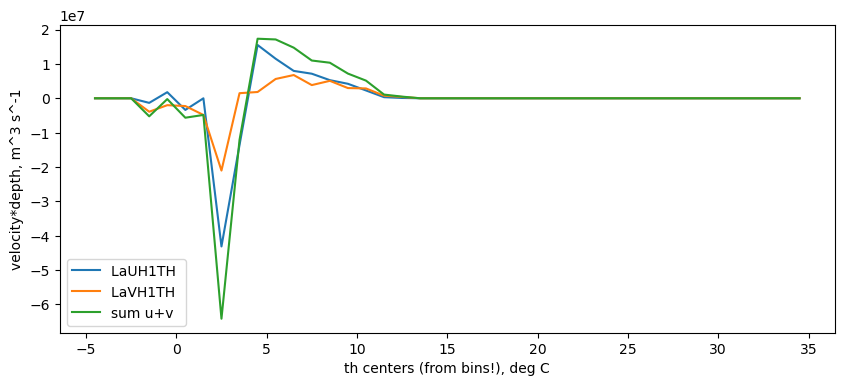

In [60]:
fig = plt.figure()
labels = np.array(['LaUH1TH ' ,'LaVH1TH ' ,'LaUH2RHO' ,'LaVH2RHO'])

print(diags_layers[0].shape)
volume_transp_u = diags_layers[0] * dyg[None,:,:]   # m^2/s * m
u_sum = volume_transp_u.sum(axis=(1,2))
plt.plot(binavg,u_sum,label=labels[0])

volume_transp_v = diags_layers[1] * dxg[None,:,:]   # m^2/s * m
v_sum = volume_transp_v.sum(axis=(1,2))
plt.plot(binavg,v_sum,label=labels[1])

# plotting these together
uv_sum = u_sum + v_sum
plt.plot(binavg,uv_sum,label="sum u+v")
    
plt.xlabel("th centers (from bins!), deg C")
plt.ylabel("velocity*depth, m^3 s^-1")

plt.legend(loc="best")

In [146]:
gdims,i0s,ies,timeStepNumber,timeInterval,map2gl,meta = readmeta(dir_diags + "diagsState.0000000010.meta")

# gdims,i0s,ies,timeStepNumber,timeInterval,map2gl,meta = readmeta(dir_diags + "diagsTrsp.0000000010.meta")

meta

{'nDims': [3],
 'dataprec': ['float32'],
 'nrecords': [2],
 'missingValue': [-999.0],
 'nFlds': [2],
 'fldList': ['THETA', 'SALT'],
 'dimList': [20, 16, 23]}

(23, 16, 20)
(23, 16, 21)
(23, 16, 20)
(23, 17, 20)
(23, 16, 20)


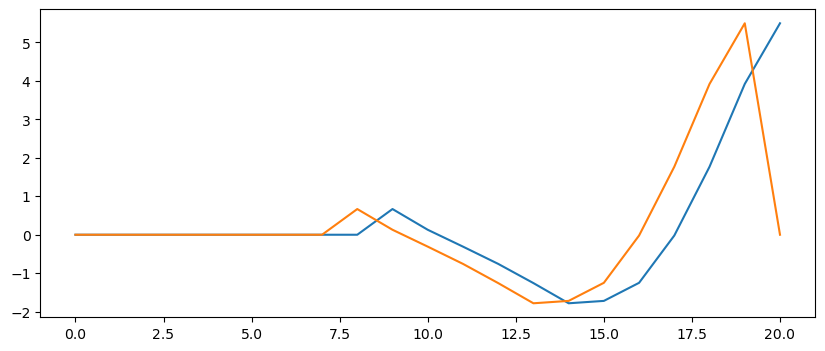

In [86]:
# verification
# read in values
diagState = rdmds(dir_diags + "diagsState", 10)
transp = rdmds(dir_diags + "diagsTrsp",10)

# center, these are tracers
TH = diagState[0]
SALT = diagState[1]

# edge
U = transp[0]
V = transp[1]

# interpolating in theta to get data at the edge
print(TH.shape)

# verifying where we added this
TH_x = np.concatenate((np.zeros((23,16,1)),TH),axis=2)
print(TH_x.shape)
TH_bad = np.concatenate((TH,np.zeros((23,16,1))),axis=2)
plt.plot(TH_x[0,0,:])
plt.plot(TH_bad[0,0,:])

# now we can move these
TH_x_padded = np.concatenate((np.zeros((23,16,1)),TH),axis=2)
TH_x = (TH_x_padded[:, :, :-1] + TH_x_padded[:, :, 1:]) * 0.5
print(TH_x.shape)

# wrong but we can do this in y later
TH_y_padded = np.concatenate((np.zeros((23,1,20)),TH),axis=1)
print(TH_y_padded.shape)
TH_y = (TH_y_padded[:, :-1, :] + TH_y_padded[:, 1:, :]) * 0.5
print(TH_y.shape)


# WRONG BELOW
# are we binning based on the average TH in depth?
# maybe try taking a sum along depth first
# TH = np.average(diagState[0],axis=0)
# SALT = np.average(diagState[1],axis=0)
# U = np.sum(U,axis=0)
# V = np.sum(V,axis=0)

In [102]:
# find between 2 and 3 for TH
binflat[8:10]

TH_flat = TH.flatten()
TH_flat.shape

mybinned_indices = np.where(np.logical_and(TH_flat>=2, TH_flat<3))

mybinned_indices[0]

array([  38,   59,  446,  467,  468,  488,  489,  510,  511,  512,  513,
        531,  532,  552,  667,  673,  690,  692,  712,  730,  731,  768,
        788,  789,  809,  810,  811,  812,  970,  971,  972,  973,  974,
        994, 1014, 1033, 1051, 1052, 1069, 1070, 1071, 1088, 1089, 1090,
       1109, 1110, 1131, 1132, 1133, 1134, 1291, 1295, 1315, 1334, 1353,
       1372, 1373, 1390, 1391, 1392, 1409, 1410, 1430, 1431, 1452, 1453,
       1454, 1612, 1615, 1635, 1654, 1673, 1674, 1692, 1693, 1710, 1711,
       1712, 1729, 1730, 1750, 1751, 1772, 1773, 1774, 1930, 1955, 1974,
       1993, 1994, 2012, 2013, 2030, 2031, 2032, 2049, 2050, 2070, 2071,
       2091, 2092, 2093, 2269, 2274, 2294, 2313, 2314, 2331, 2332, 2333,
       2350, 2351, 2369, 2389, 2390, 2410, 2411, 2412, 2613, 2633, 2651,
       2652, 2708, 2729, 2730, 2751, 2752, 3070, 3071, 4971, 4972, 5157,
       5158, 5176, 5177, 5178, 5179, 5195, 5196, 5197, 5198, 5199, 5213,
       5214, 5215, 5216, 5217, 5218, 5219, 5232, 52

In [135]:
# read in the dz
drf = rdmds(dirrun + "DRF",-1)
drf1 = drf.flatten()
drf3d = np.tile(drf1,(16,20,1))
drf3d = np.tile(drf,(16,20))

dxg3d = np.tile(dxg,(23,1,1)) 
dxg3d.shape
print(dxg3d[0,:,0])
print(dxg3d[:,0,0])

dyg3d = np.tile(dyg,(23,1,1)) 
dyg3d.shape
print(dyg3d[0,0,:])
print(dyg3d[:,0,0])

# verification
#drf3d[1,:,0]
#drf3d[0,:,0]  # same number

[154484.96875    148807.859375   142949.4375     136916.859375
 130717.4765625  124358.828125   117848.6640625  111194.9296875
 104405.7109375   97489.296875    90454.1015625   83308.703125
  76061.8125      68722.2421875   61298.94921875  53800.9765625 ]
[154484.96875 154484.96875 154484.96875 154484.96875 154484.96875
 154484.96875 154484.96875 154484.96875 154484.96875 154484.96875
 154484.96875 154484.96875 154484.96875 154484.96875 154484.96875
 154484.96875 154484.96875 154484.96875 154484.96875 154484.96875
 154484.96875 154484.96875 154484.96875]
[222389.859375 222389.859375 222389.859375 222389.859375 222389.859375
 222389.859375 222389.859375 222389.859375 222389.859375 222389.859375
 222389.859375 222389.859375 222389.859375 222389.859375 222389.859375
 222389.859375 222389.859375 222389.859375 222389.859375 222389.859375]
[222389.859375 222389.859375 222389.859375 222389.859375 222389.859375
 222389.859375 222389.859375 222389.859375 222389.859375 222389.859375
 222389.8593

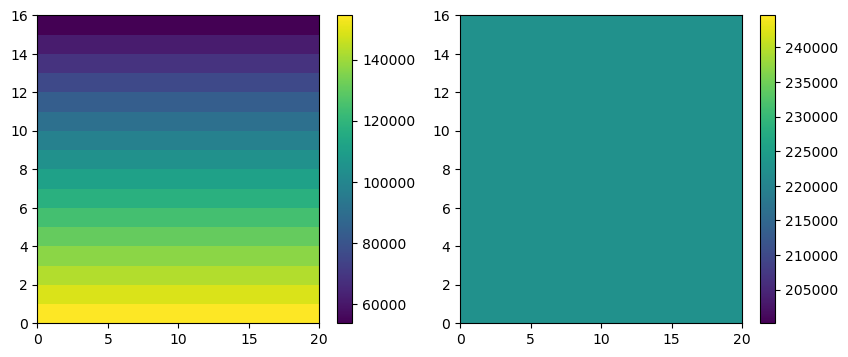

In [137]:
fig = plt.figure()

ax = plt.subplot(1,2,1)
plt.pcolormesh(dxg)
plt.colorbar()

ax1 = plt.subplot(1,2,2)
plt.pcolormesh(dyg)
plt.colorbar()

In [131]:
# we can multiply by the flatten
x_dir_transport = U * drf3d * dyg3d

# one temperature bin
x_dir_flat = x_dir_transport.flatten()
print(np.sum(x_dir_flat[mybinned_indices[0]]))

# also y transport residual
y_dir_transport = V * drf3d * dxg3d
y_dir_flat = y_dir_transport.flatten()
print(np.sum(y_dir_flat[mybinned_indices[0]]))

print(v_sum[7],u_sum[7])

-42920841.6885151
-17360028.657402072
-21031068.644551046 -43113836.8351822


In [141]:
# def closest_bin(value, bins):
#     idx = np.abs(bins - value).argmin()
#     return idx

u_sum_offline = np.zeros(binavg.shape)
v_sum_offline = np.zeros(binavg.shape)


for i in range(len(binflat[:-1])):
    mybinned_indices = np.where(np.logical_and(TH_flat>=binflat[i], TH_flat<binflat[i+1]))

    temp_x = np.sum(x_dir_flat[mybinned_indices[0]])
    u_sum_offline[i] = temp_x

    temp_y = np.sum(y_dir_flat[mybinned_indices[0]])
    v_sum_offline[i] = temp_y

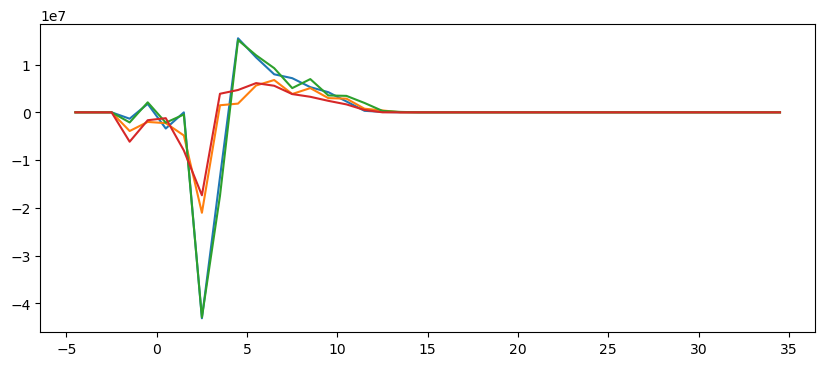

In [142]:
plt.plot(binavg,u_sum,label=labels[0])
plt.plot(binavg,v_sum,label=labels[0])
plt.plot(binavg,u_sum_offline,label=labels[0])
plt.plot(binavg,v_sum_offline,label=labels[0])

In [143]:
TH_x.shape

(23, 16, 20)

In [144]:
for i in range(len(binflat[:-1])):
    mybinned_indices = np.where(np.logical_and(TH_x.flatten()>=binflat[i], TH_x.flatten()<binflat[i+1]))
    temp_x = np.sum(x_dir_flat[mybinned_indices[0]])
    u_sum_offline[i] = temp_x

    mybinned_indices = np.where(np.logical_and(TH_y.flatten()>=binflat[i], TH_y.flatten()<binflat[i+1]))
    temp_y = np.sum(y_dir_flat[mybinned_indices[0]])
    v_sum_offline[i] = temp_y

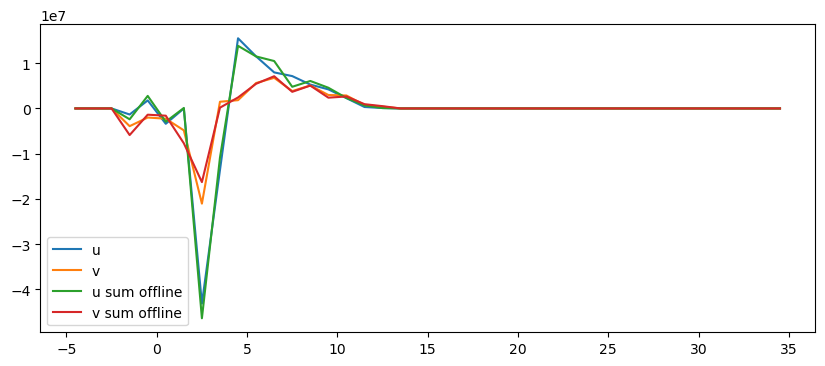

In [150]:
plt.plot(binavg,u_sum,label="u")
plt.plot(binavg,v_sum,label="v")
plt.plot(binavg,u_sum_offline,label="u sum offline")
plt.plot(binavg,v_sum_offline,label="v sum offline")
plt.legend(loc="best")
plt.ylabel("m^3/s transport")
plt.xlabel("T")

In [130]:
# percent difference of residual
print((u_sum[7]-np.sum(x_dir_flat[mybinned_indices[0]]))/u_sum[7]*100)

print((v_sum[7]-np.sum(y_dir_flat[mybinned_indices[0]]))/v_sum[7]*100)

0.44764085229735484
17.455318363482718


In [ ]:
# plotting these toge

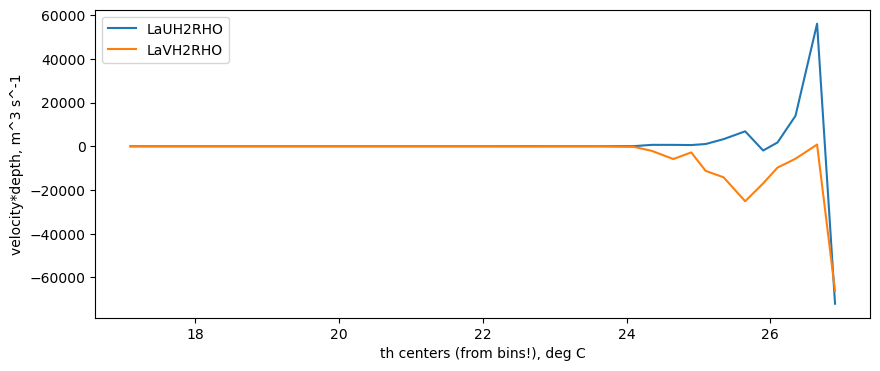

In [21]:
fig = plt.figure()
labels = np.array(['LaUH1TH ' ,'LaVH1TH ' ,'LaUH2RHO' ,'LaVH2RHO'])
for t in range(2,4):
    volume_transp = diags_layers[t] * depth[None,:,:]
    v_sum = volume_transp.sum(axis=(1,2))

    # picking grid point 9,8
    plt.plot(binavgrho,v_sum,label=labels[t])
    plt.xlabel("th centers (from bins!), deg C")
    plt.ylabel("velocity*depth, m^3 s^-1")

plt.legend(loc="best")

### TS diagram? This has to be taken from Helen's most recent run

In [33]:
# I need to rerun for salinity

# fig = plt.figure()

# plt.scatter()
# volume

### Try to make a quiver plot of u

In [34]:
T_S = rdmds(dir_diags + "diagsState",10)
metaT = readmeta(dir_diags + "diagsState.0000000010.meta")
metaTrans = readmeta(dir_diags + "diagsTrsp.0000000010.meta")

In [35]:
transp = rdmds(dir_diags + "diagsTrsp",10)

In [36]:
# let's recalculate u and v to take the cgrid averages as An recommended
'''given by our model
        tracers at center
        v at lower edge
        u at both L and R edge
'''
# average of left and right
u_edge = (transp[0, :, :, :-1] + transp[0, :, :, 1:]) * 0.5
# at
v_lower = transp[1, :, 1:, :]

print(u_edge.shape,v_lower.shape)
# we need to pad these to make them the right shape

# edge padding
u_padded = np.pad(u_edge, ((0,0), (0,0), (0,1)), mode='edge')
v_padded = np.pad(v_lower, ((0,0), (0,1), (0,0)), mode='edge')
print(u_padded.shape,v_padded.shape)

# try to do uvmag but ask An about this layer

(23, 16, 19) (23, 15, 20)
(23, 16, 20) (23, 16, 20)


In [37]:
uvmag = np.sqrt(u_padded**2 + v_padded**2)

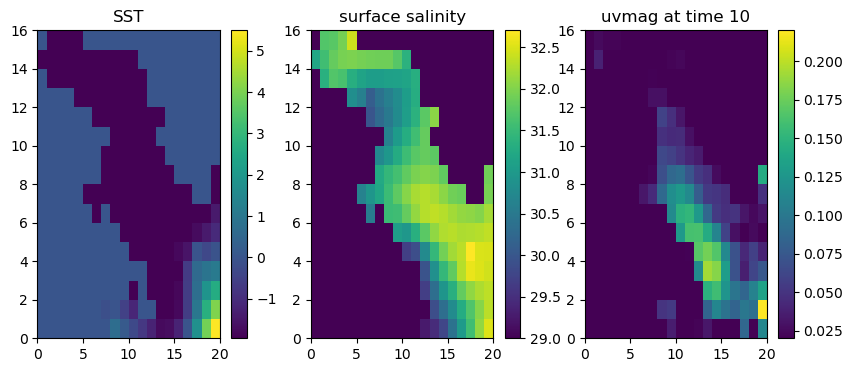

In [38]:
# plot
fig = plt.figure()

uvmag = np.sqrt(transp[0]**2 + transp[1]**2)    # INACCURATE

plt.subplot(1,3,1)
plt.title("SST")
plt.pcolormesh(T_S[0,0,:,:])
plt.colorbar()

plt.subplot(1,3,2)
plt.title("surface salinity")
plt.pcolormesh(T_S[1,0,:,:],vmin=29)
plt.colorbar()

plt.subplot(1,3,3)
plt.title("uvmag at time 10")
plt.pcolormesh(uvmag[0,:,:],vmin=0.02)
plt.colorbar()

In [39]:
# binning and multiplying
# try quiver plot
# try depth of bin * velocity to get m^3/s

# this might have multiple bins, we can do a volume sum and plot on a linear scale with temperature

### See if we can get the same figures using diagState as we did with layers

In [40]:
# our previous code was diags_layers = rdmds(dir_diags + "DiagOcnLAYERS", 10)
diagState = rdmds(dir_diags + "diagsState", 10)
print(diagState.shape)
transp = rdmds(dir_diags + "diagsTrsp",10)
print(transp.shape)  #u is index 0, v is 1
depth = rdmds(dirrun + "Depth",-1)
print(depth.shape)

(2, 23, 16, 20)
(2, 23, 16, 20)
(16, 20)


In [46]:
binTH_edge = np.arange(-5,35.2,1)
binTH_avg = (binTH_edge[:-1] + binTH_edge[1:])/2
binRHO_edge = np.arange(19,27.2,0.2)
binRHO_avg = (binRHO_edge[:-1] + binRHO_edge[1:])/2

TH = diagState[0]
print(TH.shape)
RHO = diagState[1]

U = transp[0]
V = transp[1]

# are we binning based on the average TH in depth?
# maybe try taking a sum along depth first
TH = np.average(diagState[0],axis=0)
RHO = np.average(diagState[1],axis=0)
U = np.sum(U,axis=0)
V = np.sum(V,axis=0)
print(U.shape)

(23, 16, 20)
(16, 20)


In [48]:
def closest_bin(value, bins):
    idx = np.abs(bins - value).argmin()
    return idx

U_test_th_bin = np.zeros((binTH_avg.shape[0], U.shape[0], U.shape[1]))
U_test_rho_bin = np.zeros((binRHO_avg.shape[0], U.shape[0], U.shape[1]))

for i in range(U.shape[0]):
    for j in range(U.shape[1]):
        thisT = TH[i,j]
        thisRHO = RHO[i,j]

        temp_bin_idx = closest_bin(thisT, binTH_avg)
        rho_bin_idx = closest_bin(thisRHO, binRHO_avg)

        U_test_th_bin[temp_bin_idx, i, j] = U[i,j]
        U_test_rho_bin[rho_bin_idx, i, j] = U[i,j]

In [51]:
TH = diagState[0]
RHO = diagState[1]

U = transp[0]
V = transp[1]

# keep track of the new layers files for each
U_avg_th_bin = np.zeros((binTH_avg.shape[0], U.shape[0], U.shape[1]))
U_avg_rho_bin = np.zeros((binRHO_avg.shape[0], U.shape[0], U.shape[1]))
V_avg_th_bin = np.zeros((binTH_avg.shape[0], V.shape[0], V.shape[1]))
V_avg_rho_bin = np.zeros((binRHO_avg.shape[0], V.shape[0], V.shape[1]))

# keep track of the new average velocity for each of the th and rho bins
U_sum_th_bin = np.zeros((binTH_avg.shape[0], U.shape[1], U.shape[2]))
U_count_th_bin = np.zeros((binTH_avg.shape[0], U.shape[1], U.shape[2]))
U_sum_rho_bin = np.zeros((binRHO_avg.shape[0], U.shape[1], U.shape[2]))
U_count_rho_bin = np.zeros((binRHO_avg.shape[0], U.shape[1], U.shape[2]))


for i in range(U.shape[0]):
    for j in range(U.shape[1]):
        for k in range(U.shape[2]):
            thisT = TH[i,j,k]
            thisRHO = RHO[i,j,k]

            temp_bin_idx = closest_bin(thisT, binTH_avg)
            rho_bin_idx = closest_bin(thisRHO, binRHO_avg)

            U_sum_th_bin[temp_bin_idx, j, k] += U[i,j,k]
            U_count_th_bin[temp_bin_idx, j, k] += 1

            U_sum_rho_bin[rho_bin_idx, j, k] += U[i,j,k]
            U_count_rho_bin[rho_bin_idx, j, k] += 1

U_avg_th_bin = np.where(U_count_th_bin != 0, U_sum_th_bin / U_count_th_bin, 0)
U_avg_rho_bin = np.where(U_count_rho_bin != 0, U_sum_rho_bin / U_count_rho_bin, 0)

/tmp/ipykernel_31034/3931665176.py:35: RuntimeWarning: invalid value encountered in divide
  U_avg_th_bin = np.where(U_count_th_bin != 0, U_sum_th_bin / U_count_th_bin, 0)
/tmp/ipykernel_31034/3931665176.py:36: RuntimeWarning: invalid value encountered in divide
  U_avg_rho_bin = np.where(U_count_rho_bin != 0, U_sum_rho_bin / U_count_rho_bin, 0)


In [52]:
# lets try sum
# keep track of the new layers files for each
U_avg_th_bin = np.zeros((binTH_avg.shape[0], U.shape[0], U.shape[1]))
U_avg_rho_bin = np.zeros((binRHO_avg.shape[0], U.shape[0], U.shape[1]))
V_avg_th_bin = np.zeros((binTH_avg.shape[0], V.shape[0], V.shape[1]))
V_avg_rho_bin = np.zeros((binRHO_avg.shape[0], V.shape[0], V.shape[1]))

# keep track of the new average velocity for each of the th and rho bins
U_sum_th_bin = np.zeros((binTH_avg.shape[0], U.shape[1], U.shape[2]))
U_sum_rho_bin = np.zeros((binRHO_avg.shape[0], U.shape[1], U.shape[2]))


for i in range(U.shape[0]):
    for j in range(U.shape[1]):
        for k in range(U.shape[2]):
            thisT = TH[i,j,k]
            thisRHO = RHO[i,j,k]

            temp_bin_idx = closest_bin(thisT, binTH_avg)
            rho_bin_idx = closest_bin(thisRHO, binRHO_avg)

            U_sum_th_bin[temp_bin_idx, j, k] += U[i,j,k]

            U_sum_rho_bin[rho_bin_idx, j, k] += U[i,j,k]

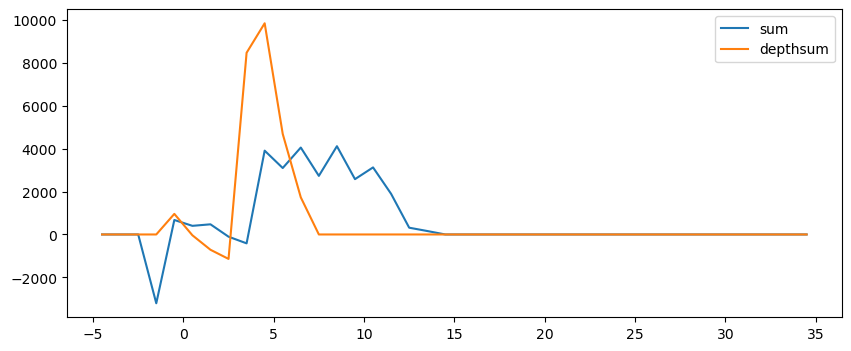

In [54]:
fig = plt.figure()
# labels = np.array(['U_avg_th ' ,'V_avg_th '])
labels = np.array(['sum' ,'avg','depthsum'])

# with sum
volume_t_th = U_sum_th_bin * depth[None,:,:]
v_sum = volume_t_th.sum(axis=(1,2))
plt.plot(binTH_avg,v_sum,label=labels[0])

# # with average
# volume_t_th = U_avg_th_bin * depth[None,:,:]
# v_sum = volume_t_th.sum(axis=(1,2))
# plt.plot(binTH_avg,v_sum,label=labels[1])

# with depth summation
volume_t_th = U_test_th_bin * depth[None,:,:]
v_sum = volume_t_th.sum(axis=(1,2))
plt.plot(binTH_avg,v_sum,label=labels[2])

plt.legend(loc="best")

### Try plotting the basic one I did in one grid square

In [32]:
plt.plot(binavg,U_avg_th_bin[:,8,9])
plt.xlabel("th centers (from bins!), deg C")
plt.ylabel("LaUH1TH, m^2 s^-1")

NameError: name 'U_avg_th_bin' is not defined